In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#read the input drug-metabolite data
data = pd.read_csv('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\data\\Paclitaxel_metabolic_NCI.csv')
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-[6-deoxy-a-L-galactopyranosyl-(1->4)]-O-b-D-galactopyranosyl-(1->4)-O-[6-deoxy-a-L-galactopyranosyl-(1->3)]-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso6] ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso3]","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),cells,Cell names,Paclitaxel
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,0.036367,0.025836,0.075427,0.036502,0.019935,0.032820,0.039391,BT549,BR:BT-549,5.573385
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,0.024981,0.013982,0.054200,0.029125,0.010750,0.015981,0.035154,HS578T,BR:HS 578T,6.502923


In [3]:
#drop the target drug column
drug = data.pop('Paclitaxel')

In [4]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()

In [5]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')
X = X[rep_meta]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [6]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [7]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [8]:
X.shape, y.shape

((52, 197), (52,))

In [9]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    29
1    23
dtype: int64

In [10]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [11]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,1.380648,-0.192857,-0.803361,-0.792265,0.150576,-0.624036,0.138105,-0.497377,-0.465306,0.654028,...,-1.109188,-1.018606,-0.370517,-1.118381,0.824582,-1.257120,-0.403498,0.357525,-0.687638,1.091285
1,-0.295557,0.549983,-0.450189,-0.169554,0.700343,-0.336542,-1.118688,-1.075044,-1.116409,1.168003,...,-0.716451,-0.183180,-1.129415,0.032274,-0.886678,-1.116138,-1.085592,-2.089173,-1.563230,0.723734


In [12]:
X.shape, y.shape

((58, 197), (58,))

In [13]:
y.value_counts()

1    29
0    29
dtype: int64

In [14]:
X.shape

(58, 197)

In [15]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [16]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 76
Number of features selected during iteration 1: 62
Number of features selected during iteration 2: 70
Number of features selected during iteration 3: 72
Number of features selected during iteration 4: 74
Number of features selected during iteration 5: 76
Number of features selected during iteration 6: 72
Number of features selected during iteration 7: 68
Number of features selected during iteration 8: 68
Number of features selected during iteration 9: 71
Number of features selected during iteration 10: 69
Number of features selected during iteration 11: 63
Number of features selected during iteration 12: 78
Number of features selected during iteration 13: 75
Number of features selected during iteration 14: 67
Number of features selected during iteration 15: 78
Number of features selected during iteration 16: 65
Number of features selected during iteration 17: 73
Number of features selected during iteration 18: 65
Number of features sel

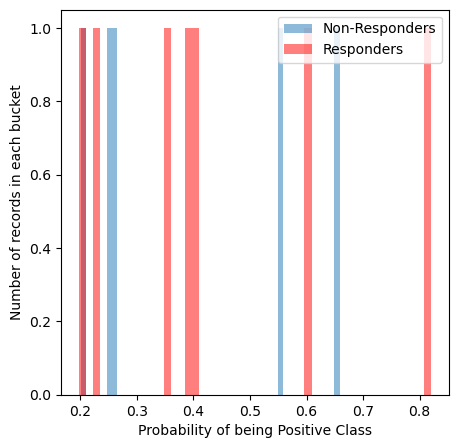

In [17]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5, bins = 50)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [18]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [19]:
df1

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.380648,-0.192857,-0.803361,-0.792265,0.150576,-0.624036,0.138105,-0.497377,-0.465306,0.654028,...,-0.370517,-1.118381,0.824582,-1.257120,-0.403498,0.357525,-0.687638,1.091285,NaN,NaN
1,-0.295557,0.549983,-0.450189,-0.169554,0.700343,-0.336542,-1.118688,-1.075044,-1.116409,1.168003,...,-1.129415,0.032274,-0.886678,-1.116138,-1.085592,-2.089173,-1.563230,0.723734,NaN,NaN
2,0.882719,0.879562,-1.099324,-0.434963,0.644528,-0.739739,0.643830,0.605493,0.580329,-0.600663,...,0.085534,-0.979248,-0.121961,-1.142164,-0.263608,-0.507336,-0.573599,-0.218306,NaN,NaN
3,-1.408964,-1.460121,0.890321,0.826737,1.240663,-0.518024,0.226172,1.575038,1.697088,-0.706715,...,-0.091963,-0.261142,0.346495,0.179651,-0.352698,-0.782638,0.579920,-0.797034,NaN,NaN
4,-1.432530,-0.065096,-0.463425,0.313066,-1.328293,-0.735426,-0.815813,-0.229468,-0.574757,-0.836714,...,-1.220952,0.282221,-1.591361,1.106010,-1.997735,-0.620812,-1.087645,-0.071089,NaN,NaN
5,-0.143629,-0.065096,-0.637592,-0.157885,0.021639,-0.408351,1.056111,0.708944,0.398901,1.601882,...,-0.391339,0.513625,0.077355,0.653947,-1.373775,1.115725,0.616754,-1.054461,0.256800,0.0
6,-0.050593,-1.665925,-0.245873,0.452779,-0.501736,-0.171629,-1.207690,-0.696444,-0.839302,0.072034,...,-0.567368,-0.862171,-0.362988,0.180284,0.155041,-0.808110,-0.408489,1.722082,0.658533,0.0
7,-1.990232,-0.065096,0.368351,0.024465,-0.054415,-0.272225,-0.706515,-1.260223,-1.437047,1.538020,...,-2.078980,-0.735193,-2.040910,0.778546,-1.587553,-1.234412,-1.003572,-1.398296,NaN,NaN
8,-0.842904,-0.471500,-0.814525,-1.248060,0.639993,-0.824600,0.037717,1.185464,1.549247,-0.313697,...,0.247338,-1.038861,-0.041826,-0.852199,-0.406416,0.077476,0.239296,0.031754,NaN,NaN
9,2.352793,-1.194703,-0.027914,0.613354,0.280642,-0.618460,0.155680,0.087825,0.160082,0.210425,...,0.083645,-1.050892,0.577490,-0.191294,0.421850,0.047906,0.233725,0.590909,NaN,NaN


In [20]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(1, 199)

In [21]:
x

0.6585333333333335

In [22]:
df1_main.index.values #0 40 41 42

array([19], dtype=int64)

In [23]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define the model
model2 = SVC(C=1, gamma=1, probability=True)

#define a list to store accuracy, precision and recall 
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    
    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 70
Features selected during iteration 1: 68
Features selected during iteration 2: 66
Features selected during iteration 3: 75
Features selected during iteration 4: 72
Features selected during iteration 5: 63
Features selected during iteration 6: 65
Features selected during iteration 7: 67
Features selected during iteration 8: 76
Features selected during iteration 9: 70
Features selected during iteration 10: 75
Features selected during iteration 11: 68
Features selected during iteration 12: 65
Features selected during iteration 13: 71
Features selected during iteration 14: 68
Features selected during iteration 15: 73
Features selected during iteration 16: 65
Features selected during iteration 17: 73
Features selected during iteration 18: 70
Features selected during iteration 19: 67
Features selected during iteration 20: 69
Features selected during iteration 21: 72
Features selected during iteration 22: 69
Features selected during iteration 23: 69
Fe

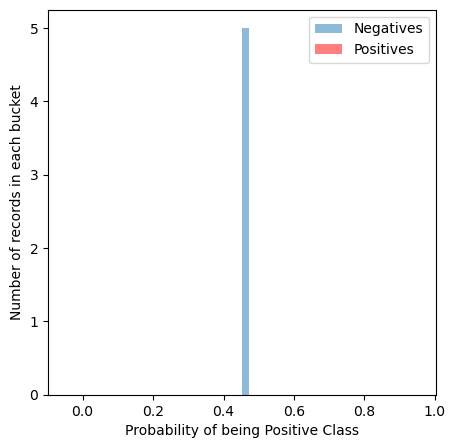

In [24]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [25]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [26]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
42,0.906206,0.865071,0.392901,-0.820334,1.223939,0.356494,1.954638,2.153024,3.001462,-0.848422,...,1.784097,-0.908045,1.709375,0.015215,0.626532,1.078283,1.387312,1.601169,0.452072,1.0


In [27]:
max(prediction2[y_test == 0])

0.4520723389376601

In [28]:
df2_main.index.values #40 41 42

array([42], dtype=int64)

In [29]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#define the model
model3 = XGBClassifier()

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    
    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 26
Features selected during iteration 1: 26
Features selected during iteration 2: 26
Features selected during iteration 3: 26
Features selected during iteration 4: 26
Features selected during iteration 5: 26
Features selected during iteration 6: 26
Features selected during iteration 7: 26
Features selected during iteration 8: 26
Features selected during iteration 9: 26
Features selected during iteration 10: 26
Features selected during iteration 11: 26
Features selected during iteration 12: 26
Features selected during iteration 13: 26
Features selected during iteration 14: 26
Features selected during iteration 15: 26
Features selected during iteration 16: 26
Features selected during iteration 17: 26
Features selected during iteration 18: 26
Features selected during iteration 19: 26
Features selected during iteration 20: 26
Features selected during iteration 21: 26
Features selected during iteration 22: 26
Features selected during iteration 23: 26
Fe

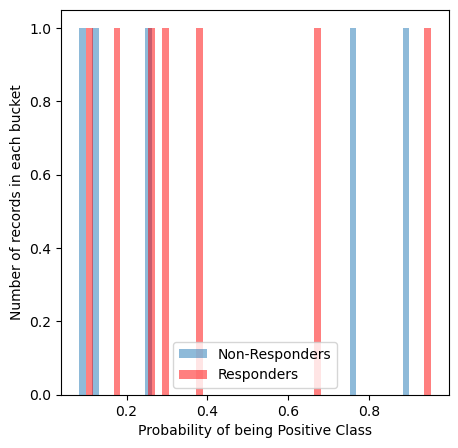

In [30]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [31]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.380648,-0.192857,-0.803361,-0.792265,0.150576,-0.624036,0.138105,-0.497377,-0.465306,0.654028,...,-0.370517,-1.118381,0.824582,-1.257120,-0.403498,0.357525,-0.687638,1.091285,NaN,NaN
1,-0.295557,0.549983,-0.450189,-0.169554,0.700343,-0.336542,-1.118688,-1.075044,-1.116409,1.168003,...,-1.129415,0.032274,-0.886678,-1.116138,-1.085592,-2.089173,-1.563230,0.723734,NaN,NaN
2,0.882719,0.879562,-1.099324,-0.434963,0.644528,-0.739739,0.643830,0.605493,0.580329,-0.600663,...,0.085534,-0.979248,-0.121961,-1.142164,-0.263608,-0.507336,-0.573599,-0.218306,NaN,NaN
3,-1.408964,-1.460121,0.890321,0.826737,1.240663,-0.518024,0.226172,1.575038,1.697088,-0.706715,...,-0.091963,-0.261142,0.346495,0.179651,-0.352698,-0.782638,0.579920,-0.797034,NaN,NaN
4,-1.432530,-0.065096,-0.463425,0.313066,-1.328293,-0.735426,-0.815813,-0.229468,-0.574757,-0.836714,...,-1.220952,0.282221,-1.591361,1.106010,-1.997735,-0.620812,-1.087645,-0.071089,NaN,NaN
5,-0.143629,-0.065096,-0.637592,-0.157885,0.021639,-0.408351,1.056111,0.708944,0.398901,1.601882,...,-0.391339,0.513625,0.077355,0.653947,-1.373775,1.115725,0.616754,-1.054461,0.259677,0.0
6,-0.050593,-1.665925,-0.245873,0.452779,-0.501736,-0.171629,-1.207690,-0.696444,-0.839302,0.072034,...,-0.567368,-0.862171,-0.362988,0.180284,0.155041,-0.808110,-0.408489,1.722082,0.763199,0.0
7,-1.990232,-0.065096,0.368351,0.024465,-0.054415,-0.272225,-0.706515,-1.260223,-1.437047,1.538020,...,-2.078980,-0.735193,-2.040910,0.778546,-1.587553,-1.234412,-1.003572,-1.398296,NaN,NaN
8,-0.842904,-0.471500,-0.814525,-1.248060,0.639993,-0.824600,0.037717,1.185464,1.549247,-0.313697,...,0.247338,-1.038861,-0.041826,-0.852199,-0.406416,0.077476,0.239296,0.031754,NaN,NaN
9,2.352793,-1.194703,-0.027914,0.613354,0.280642,-0.618460,0.155680,0.087825,0.160082,0.210425,...,0.083645,-1.050892,0.577490,-0.191294,0.421850,0.047906,0.233725,0.590909,NaN,NaN


In [32]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
42,0.906206,0.865071,0.392901,-0.820334,1.223939,0.356494,1.954638,2.153024,3.001462,-0.848422,...,1.784097,-0.908045,1.709375,0.015215,0.626532,1.078283,1.387312,1.601169,0.953376,1.0


In [33]:
max(prediction3[y_test == 0])

0.8990694

In [34]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [35]:
cl = set(common_list) #13 19 41 42
cl

{19, 42}

In [36]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
13,-0.427938,0.259906,-0.530520,2.548468,-0.023273,-0.403284,-0.981444,-0.077092,-0.274950,0.098766,...,0.775537,0.970566,0.183444,-0.111230,1.356116,0.049309,0.405104,-0.890275,0.197733,1.0
19,1.460752,-1.786685,-1.198205,-0.900747,0.242115,-1.177019,0.115959,0.447375,0.657836,-1.245033,...,-0.005919,-1.039260,-0.359650,-1.100519,-0.305855,-0.073044,-0.455977,0.745804,0.820533,1.0
22,0.310673,-0.065096,2.491509,-0.707978,-0.103109,0.185241,0.846902,0.631874,0.495127,-1.313690,...,-0.039222,-0.228099,0.075796,2.587057,0.431768,0.271487,0.543156,0.952688,0.396800,1.0
41,0.190884,0.058872,-0.309263,-0.348839,1.891346,0.080523,0.280975,0.777700,1.115396,-0.021966,...,2.341961,0.562910,1.408337,-0.601252,-0.388480,1.882391,1.167939,-0.209962,0.232133,1.0
42,0.906206,0.865071,0.392901,-0.820334,1.223939,0.356494,1.954638,2.153024,3.001462,-0.848422,...,1.784097,-0.908045,1.709375,0.015215,0.626532,1.078283,1.387312,1.601169,0.596400,1.0
50,-1.490377,-0.173820,-0.691940,-0.531172,0.647791,-0.529944,-1.284190,1.693287,1.102635,0.111090,...,0.299763,0.316895,0.174577,0.064326,-0.297901,0.641413,1.195908,0.853815,0.358667,1.0


In [37]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [38]:
l = []
l.extend(df1_total.index.values)
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')